# TUR-1577: Proxy for incremental sales

This analysis attempts to figure out the relationship between our predictions (in terms of ordering) with Safari Incremental Sales.

In [1]:
import os
os.environ['GOOGLE_APPLICATION_CREDENTIALS']=f"/home/jovyan/.config/gcloud/legacy_credentials/{os.getenv('JUPYTERHUB_USER')}/adc.json" 

import pandas as pd
pd.set_option('display.max_columns', None)

import numpy as np
import matplotlib.pyplot as plt

from google.cloud import bigquery
bq = bigquery.Client(project='gcp-wow-rwds-ai-mmm-super-dev')

In [2]:
FIGSIZE = (7.5, 7.5)

In [3]:
sql = '''
    WITH pred AS (
    SELECT 
        crn,
        target_spd AS p_target_spd,
        target_spd - base_spd AS p_inc_sales,
        (target_spd - base_spd) / target_spd AS p_r_inc_sales,
        p_rdm * (target_spd - base_spd) AS p_inc_sales_propensity,
        p_rdm,
    FROM `gcp-wow-rwds-ai-mmm-prod.PROD_MMM.MMM_MODEL_SCORE_DATA` 
    WHERE campaign_type_long NOT IN (
            'None', 
            'dns', 
            'reactivation 3 week store', 
            'online spend get 2 week store'
        )
        AND campaign_start_date = '{execution_date}'
    ), 
    actual AS (
        SELECT 
            crn,
            offer_type,
            SUM(weekly_inc_sales) AS a_inc_sales
        FROM `gcp-wow-rwds-ai-mmm-prod.PROD_MMM.MMM_POST_BQ_MASTER_AUDIENCE`
        WHERE campaign_start_date = '{execution_date}'
            AND Model = 'R'
        GROUP BY 1,2
    )
    SELECT 
        p.crn,
        a.offer_type,
        p.p_target_spd,
        p.p_inc_sales,
        p.p_r_inc_sales,
        p_inc_sales_propensity,
        p_rdm,
        a.a_inc_sales
    FROM pred p 
        JOIN actual a on p.crn = a.crn
'''

In [4]:
def enrich(df):
    min_p_inc_sales = df['p_inc_sales'].min()
    max_p_inc_sales = df['p_inc_sales'].max()
    df['p_inc_sales_norm'] = (df['p_inc_sales'] - min_p_inc_sales) / (max_p_inc_sales - min_p_inc_sales)
    df['combo'] = df['p_rdm'] + df['p_inc_sales_norm']
    
    return df

## Cumulative incremental sales

In [7]:
def custom_plot(df, title='Hello friend'):
    
    def _custom_plot(df, by, label):
        df_sorted = df.sort_values(by=by, ascending=False).reset_index(drop=True)
        df_sorted = df_sorted.reset_index()
        df_sorted['rank'] = (df_sorted['index'] + 1) / len(df_sorted)
        df_sorted['a_inc_sales_cum'] = df_sorted['a_inc_sales'].cumsum()
        plt.plot(df_sorted['rank'], df_sorted['a_inc_sales_cum'], label=label)
        

    plt.figure(figsize=FIGSIZE)
    plt.title(title)
    
#     _custom_plot(df, 'a_inc_sales', 'incremental sales')
#     _custom_plot(df, 'p_inc_sales', 'incremental sales')
#     _custom_plot(df, 'p_r_inc_sales', 'relative incremental sales')
#     _custom_plot(df, 'p_target_spd', 'target spend')
    _custom_plot(df, 'p_rdm', 'redemption rate')
#     _custom_plot(df, 'p_inc_sales_propensity', 'incremental sales propensity')
#     _custom_plot(df, 'combo', "Joe's combo")
    
    plt.xlabel('rank')
    plt.ylabel('Safari incremental sales (cumulative)')
    plt.grid()
    plt.legend()

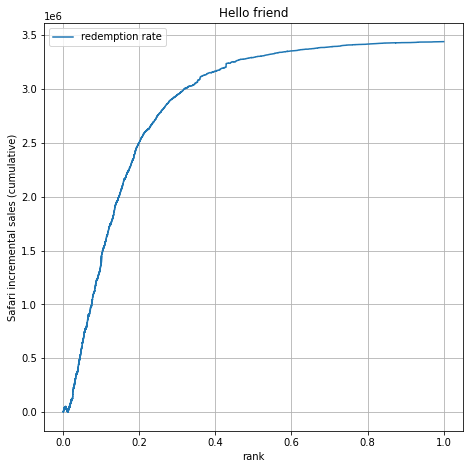

In [8]:
# adhoc
df = bq.query(sql.format(execution_date='2021-12-06')).result().to_dataframe()
custom_plot(df)

### By execution dates

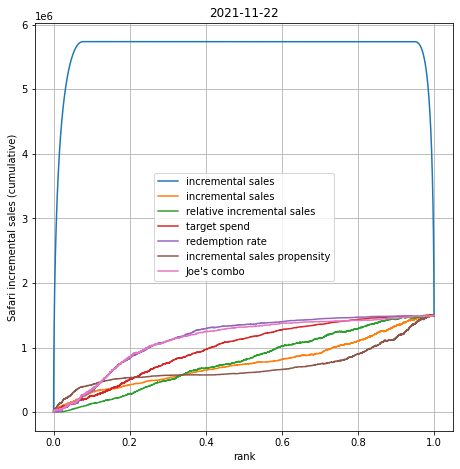

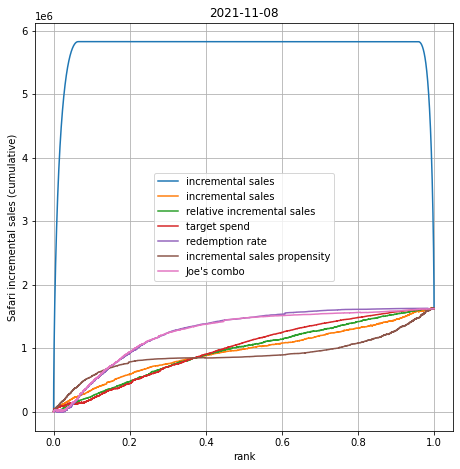

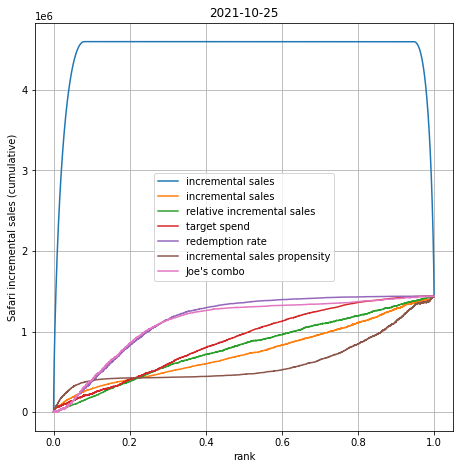

/home/jovyan/my-conda-envs/sandbox/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


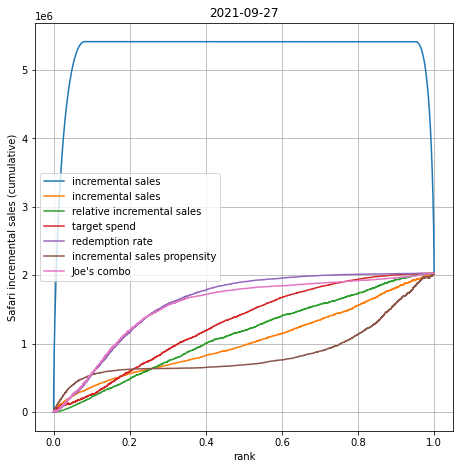

In [6]:
EXECUTION_DATES = ['2021-12-06', '2021-11-22', '2021-11-08', '2021-10-25', '2021-10-11', '2021-09-27']

for execution_date in EXECUTION_DATES:
    df = bq.query(sql.format(execution_date=execution_date)).result().to_dataframe()
    df = enrich(df)
    custom_plot(df, execution_date)

### By offer types

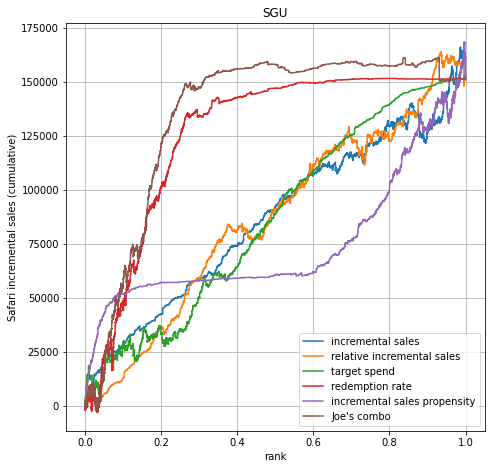

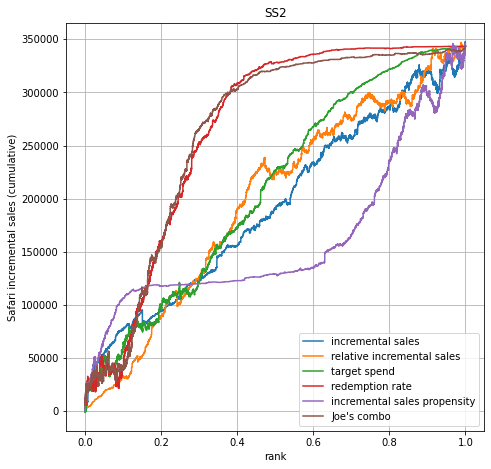

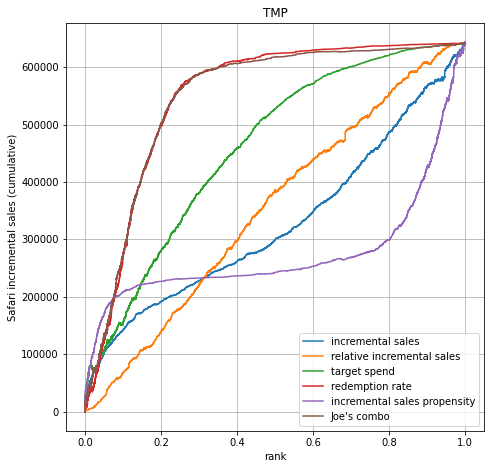

In [8]:
EXECUTION_DATE = '2021-12-06'
df = bq.query(sql.format(execution_date=EXECUTION_DATE)).result().to_dataframe()
df = enrich(df)
OFFER_TYPES = list(df.offer_type.unique())
OFFER_TYPES.sort()

for offer_type in OFFER_TYPES:
    df_offer = df[df['offer_type'] == offer_type]
    custom_plot(df_offer, offer_type)

## Positive incremental sales

In [9]:
def pos_custom_plot(df, title='Hello friend'):
    
    def _custom_plot(df, by, label):
        df_sorted = df.sort_values(by=by, ascending=False).reset_index(drop=True)
        df_sorted = df_sorted.reset_index()
        df_sorted['rank'] = (df_sorted['index'] + 1) / len(df_sorted)
        df_sorted['percentile'] = np.ceil(df_sorted['rank'] * 100)
        df_sorted = df_sorted.groupby('percentile').aggregate({'a_inc_sales_pos': 'mean'}).reset_index()
        plt.plot(df_sorted['percentile'], df_sorted['a_inc_sales_pos'], label=label)
        

    plt.figure(figsize=FIGSIZE)
    plt.title(title)
    
    new_df = df.copy()
    new_df['a_inc_sales_pos'] = new_df['a_inc_sales'].apply(lambda x: 1 if x > 0 else 0)

    _custom_plot(new_df, 'p_inc_sales', 'incremental sales')
    _custom_plot(new_df, 'p_r_inc_sales', 'relative incremental sales')
    _custom_plot(new_df, 'p_target_spd', 'target spend')
    _custom_plot(new_df, 'p_rdm', 'redemption rate')
    _custom_plot(new_df, 'p_inc_sales_propensity', 'incremental sales propensity')
    
    plt.xlabel('percentile')
    plt.ylabel('proportion with positive Safari incremental sales')
    plt.grid()
    plt.legend()

In [10]:
# # adhoc
# df = bq.query(sql.format(execution_date='2021-12-06')).result().to_dataframe()
# pos_custom_plot(df)

### By execution dates

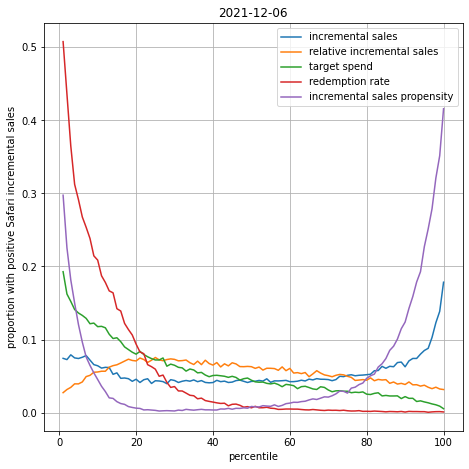

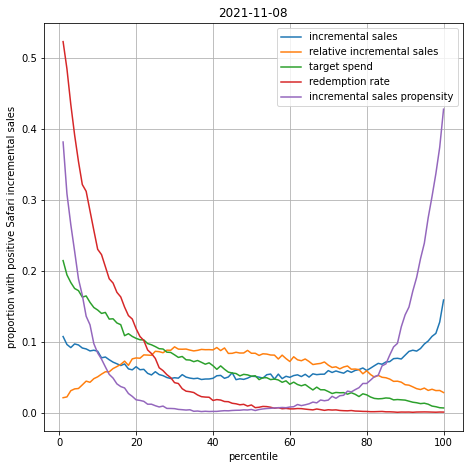

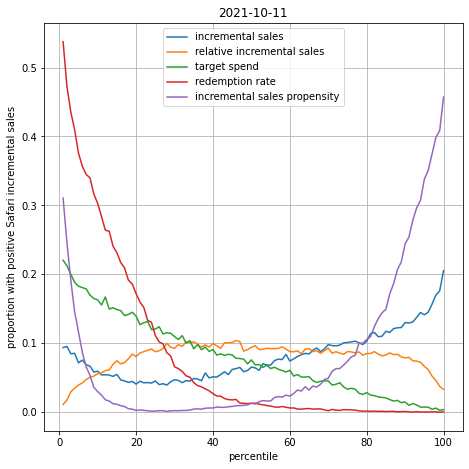

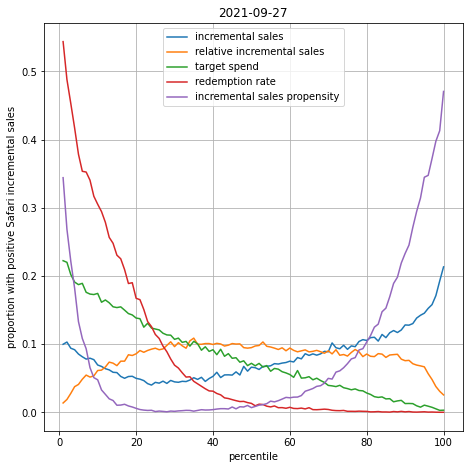

In [11]:
EXECUTION_DATES = ['2021-12-06', '2021-11-22', '2021-11-08', '2021-10-25', '2021-10-11', '2021-09-27']

for execution_date in EXECUTION_DATES:
    df = bq.query(sql.format(execution_date=execution_date)).result().to_dataframe()
    df = enrich(df)
    pos_custom_plot(df, execution_date)

### By offer types

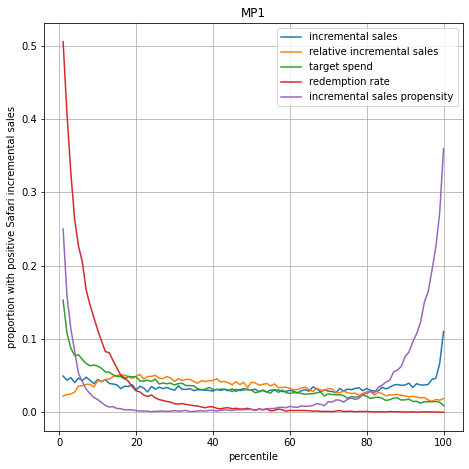

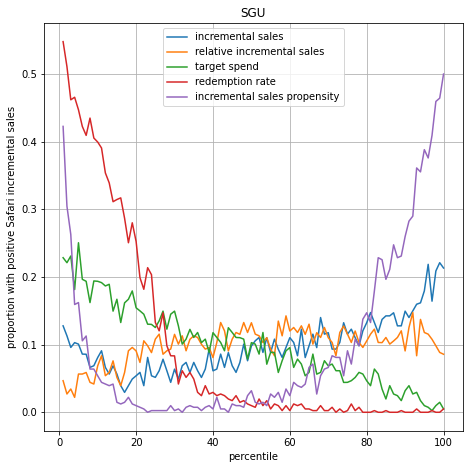

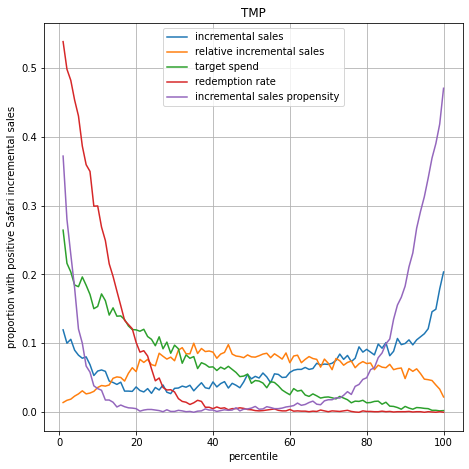

In [12]:
EXECUTION_DATE = '2021-12-06'
df = bq.query(sql.format(execution_date=EXECUTION_DATE)).result().to_dataframe()
df = enrich(df)
OFFER_TYPES = list(df.offer_type.unique())
OFFER_TYPES.sort()

for offer_type in OFFER_TYPES:
    df_offer = df[df['offer_type'] == offer_type]
    pos_custom_plot(df_offer, offer_type)

## Other explorations

### Relationship between different predictors

In [13]:
test = df.sort_values(by='p_rdm').reset_index(drop=True)
test = test.reset_index()
test['p_inc_sales_pos'] = test['p_inc_sales'].apply(lambda x: 1 if x > 0 else 0)
test['a_inc_sales_pos'] = test['a_inc_sales'].apply(lambda x: 1 if x > 0 else 0)

test['rank'] = (test['index'] + 1) / len(test)
test['percentile'] = np.ceil(test['rank'] * 100)

test = test.groupby('percentile').aggregate({
    'p_rdm':'mean', 
    'p_inc_sales': 'mean',
    'p_inc_sales_propensity': 'mean',
    'p_inc_sales_pos':'mean',
    'a_inc_sales_pos':'mean',
    'a_inc_sales':'mean'}
).reset_index()

In [14]:
# plt.figure(figsize=FIGSIZE)
# plt.plot(test.p_inc_sales, test.a_inc_sales, '.-', label = 'p_rd)
# plt.grid()
# plt.legend()
# plt.xlabel('p_rdm')
# plt.ylabel('Safari incremental sales')
# plt.show()


In [15]:
fig, ax = plt.subplots(1,2,figsize=(15, 7.5))
ax[0].plot(test.percentile, test.p_inc_sales_propensity, label = 'p_inc_sales_propensity')
ax[0].plot(test.percentile, test.p_inc_sales, label = 'p_inc_sales')
ax[0].plot(test.percentile, test.a_inc_sales, label = 'a_inc_sales')
ax[1].plot(test.percentile, test.p_inc_sales_pos, label = 'p_inc_sales_pos')
ax[1].plot(test.percentile, test.a_inc_sales_pos, label = 'a_inc_sales_pos')

for i in range(2):
    ax[i].grid()
    ax[i].legend()
    ax[i].set_xlabel('p_rdm percentile')
    
plt.show()

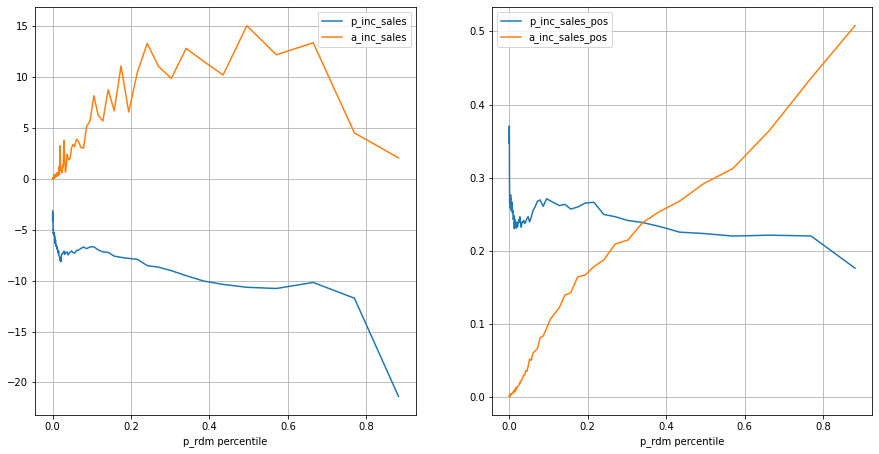

In [16]:
fig, ax = plt.subplots(1,2,figsize=(15, 7.5))
ax[0].plot(test.p_rdm, test.p_inc_sales, label = 'p_inc_sales')
ax[0].plot(test.p_rdm, test.a_inc_sales, label = 'a_inc_sales')
ax[1].plot(test.p_rdm, test.p_inc_sales_pos, label = 'p_inc_sales_pos')
ax[1].plot(test.p_rdm, test.a_inc_sales_pos, label = 'a_inc_sales_pos')

for i in range(2):
    ax[i].grid()
    ax[i].legend()
    ax[i].set_xlabel('p_rdm percentile')
    
plt.show()

### Model cohort

In [17]:
sql_model = '''
    WITH pred AS (
    SELECT 
        crn,
        target_spd AS p_target_spd,
        target_spd - base_spd AS p_inc_sales,
        case when target_spd = 0 then 0 else (target_spd - base_spd) / target_spd end AS p_r_inc_sales,
        p_rdm * (target_spd - base_spd) AS p_inc_sales_propensity,
        p_rdm,
    FROM `gcp-wow-rwds-ai-mmm-prod.PROD_MMM.MMM_MODEL_SCORE_DATA` 
    WHERE campaign_type_long NOT IN (
            'reactivation 3 week store', 
            'online spend get 2 week store'
        )
        AND campaign_start_date = '{execution_date}'
    ), 
    actual AS (
        SELECT 
            crn,
            offer_type,
            SUM(weekly_inc_sales) AS a_inc_sales
        FROM `gcp-wow-rwds-ai-mmm-prod.PROD_MMM.MMM_POST_BQ_MASTER_AUDIENCE`
        WHERE campaign_start_date = '{execution_date}'
            AND Model = 'M'
        GROUP BY 1,2
    )
    SELECT 
        p.crn,
        a.offer_type,
        p.p_target_spd,
        p.p_inc_sales,
        p.p_r_inc_sales,
        p_inc_sales_propensity,
        p_rdm,
        a.a_inc_sales
    FROM pred p 
        JOIN actual a on p.crn = a.crn
'''

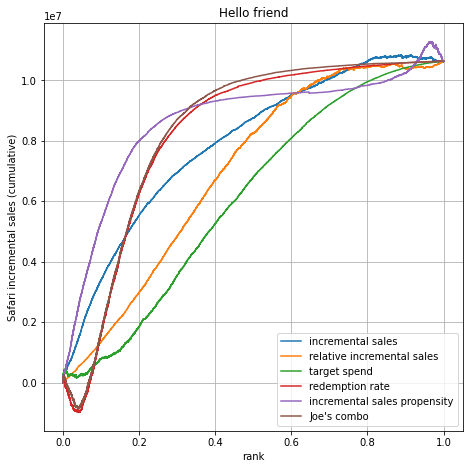

In [18]:
# adhoc
df_model = bq.query(sql_model.format(execution_date='2021-12-06')).result().to_dataframe()
df_model = enrich(df_model)
custom_plot(df_model)

### Deciding between offers

In [8]:
EXECUTION_DATE = '2021-12-06'
df = bq.query(sql.format(execution_date=EXECUTION_DATE)).result().to_dataframe()
df = enrich(df)
OFFER_TYPES = list(df.offer_type.unique())
OFFER_TYPES.sort()

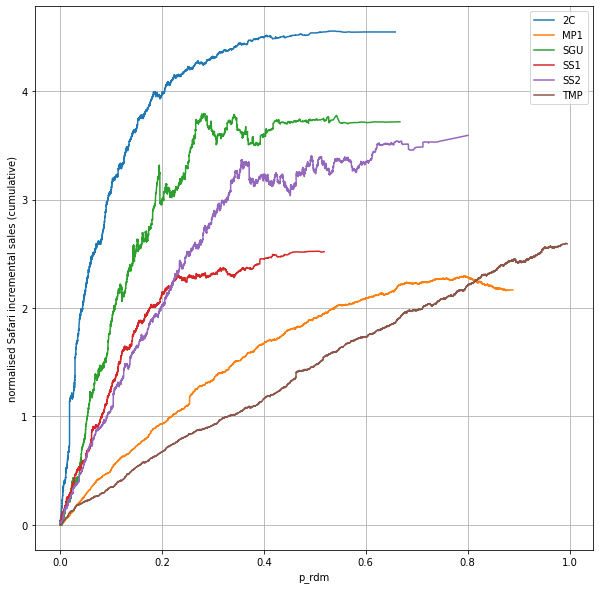

In [13]:
count_df = df.groupby('offer_type').aggregate({'crn': 'size'}).reset_index()
count_df.rename(columns={'crn':'size'}, inplace=True)
test = df.merge(count_df, left_on='offer_type', right_on='offer_type')
test['a_inc_sales'] = test['a_inc_sales'] / test['size']

plt.figure(figsize=(10,10))

for offer_type in OFFER_TYPES:
    offer_test = test[test['offer_type'] == offer_type]
    offer_test = offer_test.sort_values(by='p_rdm', ascending=True, ignore_index=True).reset_index()
    offer_test['a_inc_sales_cum'] = offer_test['a_inc_sales'].cumsum()
    offer_test['rank'] = (offer_test['index'] + 1) / len(offer_test)
    offer_test['percentile'] = np.ceil(offer_test['rank'] * 10)
    
#     offer_test = offer_test.groupby('percentile').aggregate({
#         'p_rdm':'mean', 
#         'a_inc_sales':'mean'}
#     ).reset_index()
    
    plt.plot(offer_test['p_rdm'], offer_test['a_inc_sales_cum'], label=offer_type)
    

plt.grid()
plt.legend()
plt.xlabel('p_rdm')
plt.ylabel('normalised Safari incremental sales (cumulative)')
plt.show()
